# 1. Set Up

In [1]:
!spack find -p tfel
!export PATH=/mofem_install/jupyter/thomas/um_view/bin:$PATH 
!echo $PATH
!read_med

-- linux-ubuntu20.04-x86_64 / gcc@9.4.0 -------------------------
tfel@4.0.0  /mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx
tfel@4.0.0  /mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-jjcwdu6cbil5dzqzjhjekn3jdzo3e6gc
==> 2 installed packages
/mofem_install/um_view/bin:/mofem_install/jupyter/thomas/.local/bin:/mofem_install/jupyter/thomas/.vscode/cli/servers/Stable-384ff7382de624fb94dbaf6da11977bba1ecd427/server/bin/remote-cli:/mofem_install/um_view/bin:/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/py-numpy-1.26.1-ue7volt2h7awnoymiyxjzriegzyc3rr5/bin:/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/python-3.11.6-a6ce7p54ivs64b5eohmbbwye227i4642/bin:/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/xz-5.4.1-2mwenxme6zkcsocqiwfszexdhxo7zqwt/bin:/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwm

In [2]:
# %env LD_LIBRARY_PATH=/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib

In [3]:
!echo "$(spack find -p tfel | awk '/\/mofem_install\// {print $NF "/lib"}')"

/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib
/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-jjcwdu6cbil5dzqzjhjekn3jdzo3e6gc/lib


In [4]:
import math
import os
import re
import sys
import time
from pathlib import Path
import subprocess
import zipfile
import pydantic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gmsh
from scipy import optimize
from scipy.optimize import curve_fit, least_squares

sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import setup
import core
import custom_models as cm
import utils as ut
import plotting
os.chdir('/mofem_install/jupyter/thomas/mfront_example_test')
    


# 2. Simulation Parameters

In [5]:
#in MPa
def initialize_parameters():
    params = cm.AttrDict()
    params.tester = cm.TestAttr(
        preferred_model= cm.PropertyTypeEnum.von_mises,
        props = {
            cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=150, poisson_ratio=0.3),
            cm.PropertyTypeEnum.von_mises: cm.VonMisesProperties(youngs_modulus=150, poisson_ratio=0.3, HardeningSlope = 150/100, YieldStress = 100),
            cm.PropertyTypeEnum.drucker_prager: cm.DruckerPragerProperties(youngs_modulus=96, poisson_ratio=0.3, d = 150, beta = 0.6, pa = 0.01, pb = 0.05),
            cm.PropertyTypeEnum.cam_clay: cm.CamClayProperties(),
            }, 
        
    )
 
    # the prescription is always applied to the max_y edge
    # params.prescribed_force = cm.ForceBoundaryCondition(fx=0,fy=0,fz=5000)
    # params.prescribed_disp = cm.EdgeBoundaryCondition(disp_ux=0, disp_uy={0: 0, 0.25: 1.0, 0.5: 0.6, 0.75: 1.2, 1: 0.9} ,disp_uz=0)
    params.prescribed_disp = cm.EdgeBoundaryCondition(disp_uy=1)
    params.nproc = 8 # number of processors/cores used
    params.order = 2 #order of approximation functions
    params.dim = 2
    # params.time_step = 0.05 # [s]
    params.final_time = 1 # [s]
    params.time_step = 1 / 200 # [s]
    params.wk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test")
    params.um_view = f"/mofem_install/jupyter/thomas/um_view"
    params.exe = f"tutorials/adv-1/contact_2d"
    params.use_case = "test_2D"
    return params

In [6]:
params = initialize_parameters()

# 3. Log paths and meta

In [7]:
params = setup.setup(params)

Simulation #11 for the day.


# 4. Generate the mesh

In [8]:
core.generate_mesh(params)

╭────────────────╮
│  DRAWING MESH  │
╰────────────────╯
min_x_min_y_node=1 min_x_max_y_node=4 max_x_min_y_node=2 max_x_max_y_node=3 min_x=-10.0 max_x=10.0 min_y=-10.0 max_y=10.0
Done, taken Wall Time: 0.01 seconds, CPU Time: 0.01 seconds
╭──────────────────────────────────╮
│  ADDING PHYSICAL GROUPS TO MESH  │
╰──────────────────────────────────╯
Done, taken Wall Time: 0.00 seconds, CPU Time: 0.00 seconds
╭──────────────────────╮
│  CHECKING BLOCK IDS  │
╰──────────────────────╯
{'test_day_74_sim_11': 5, 'FIX_X_0': 2, 'FIX_Y_0': 3, 'FIX_Y_1': 4}
Done, taken Wall Time: 0.32 seconds, CPU Time: 0.00 seconds
╭───────────────────────────╮
│  GENERATING CONFIG FILES  │
╰───────────────────────────╯
[PhysicalGroup(dim=2, tags=[1], name='test_day_74_sim_11', meshnet_id=5, group_type=<PhysicalGroupType.MATERIAL: 1>, preferred_model=<PropertyTypeEnum.von_mises: 'VMSimo'>, props={<PropertyTypeEnum.elastic: 'LinearElasticity'>: ElasticProperties(youngs_modulus=150.0, poisson_ratio=0.3), <Property

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-10-30 22:19:34
[0] <inform> UTC time: 2024-10-30 22:19:34
[0] <inform> [MED] Reading MED file V4.1.0 using MED library V4.1.0
[0] <inform> [MED] Check mesh test_day_74_sim_11 nsteps 1
[0] <inform> [MED] Reading mesh test_day_74_sim_11 nsteps 1
[0] <inform> [MED] Read number of nodes 98
[0] <inform> [MED] Reading elements 4 of type Vertex number of nodes 1
[0] <inform> [MED] Reading elements 32 of type Edge number of nodes 2
[0] <inform> [MED] Reading elements 162 of type Tri number of nodes 3
[0] <inform> [read_med] Print all meshsets (old and added from meshsets configurational file)
[0] <inform> [read_med] meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name test_day_74_sim_11
[0] <inform> [read_med] meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name FIX_X_0           

Done, taken Wall Time: 0.34 seconds, CPU Time: 0.00 seconds
╭─────────────────────────────────────╮
│  PARTITIONING MESH with mofem_part  │
╰─────────────────────────────────────╯
Done, taken Wall Time: 0.31 seconds, CPU Time: 0.00 seconds


[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-10-30 22:19:34
[0] <inform> UTC time: 2024-10-30 22:19:34
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name test_day_74_sim_11
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name FIX_X_0                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name FIX_Y_0                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 4 name FIX_Y_1                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 5 name test_day_74_sim_11             
[0] <inform> [MeshsetMng] meshset in data

{'tester': TestAttr(preferred_model=<PropertyTypeEnum.von_mises: 'VMSimo'>, props={<PropertyTypeEnum.elastic: 'LinearElasticity'>: ElasticProperties(youngs_modulus=150.0, poisson_ratio=0.3), <PropertyTypeEnum.von_mises: 'VMSimo'>: VonMisesProperties(youngs_modulus=150.0, poisson_ratio=0.3, HardeningSlope=1.5, YieldStress=100.0), <PropertyTypeEnum.drucker_prager: 'DruckerPragerSimple'>: DruckerPragerProperties(youngs_modulus=96.0, poisson_ratio=0.3, d=150.0, beta=0.6, pa=0.01, pb=0.05), <PropertyTypeEnum.cam_clay: 'ModCamClay_semiExpl'>: CamClayProperties(nu=0.3, M=1.2, la=0.077, ka=0.0066, v0=1.7857, pc0=400)}),
 'prescribed_disp': EdgeBoundaryCondition(disp_ux=None, disp_uy=1.0, disp_uz=None),
 'nproc': 8,
 'order': 2,
 'dim': 2,
 'final_time': 1,
 'time_step': 0.005,
 'wk_dir': PosixPath('/mofem_install/jupyter/thomas/mfront_example_test'),
 'um_view': '/mofem_install/jupyter/thomas/um_view',
 'exe': 'tutorials/adv-1/contact_2d',
 'use_case': 'test_2D',
 'time_history': False,
 'days

# 5. Running the analysis and export to .vtk file format

In [9]:
core.mofem_compute(params)

╭─────────────╮
│  COMPUTING  │
╰─────────────╯
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-10-30 22:19:35
[0] <inform> UTC time: 2024-10-30 22:19:35
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name test_day_74_sim_11
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316752 type BLOCKSET UNKNOWNNAME msId 2 name FIX_X_0                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316753 type BLOCKSET UNKNOWNNAME msId 3 name FIX_Y_0                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316751 type BLOCKSET UNKNOWNNAME msId 4 name FIX_Y_1                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 5 name test_day_74_sim_11       

In [10]:
core.export_to_vtk(params)

╭────────────────────────────────╮
│  CONVERTING FROM .htm TO .vtk  │
╰────────────────────────────────╯
Conversion to VTK successful.
Moved out_mi_93.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_day_74_sim_11_2024_10_30_22_19_33
Moved out_mi_81.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_day_74_sim_11_2024_10_30_22_19_33
Moved out_mi_7.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_day_74_sim_11_2024_10_30_22_19_33
Moved out_mi_92.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_day_74_sim_11_2024_10_30_22_19_33
Moved out_mi_80.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_day_74_sim_11_2024_10_30_22_19_33
Moved out_mi_69.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_day_74_sim_11_2024_10_30_22_19_33
Moved out_mi_91.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/test_day_74_sim_11_2024_10_30_22_19_3

# 6. Visualize final time step .vtk file

/mofem_install/jupyter/thomas/mfront_example_test/simulations/test_day_74_sim_11_2024_10_30_22_19_33/out_mi_200.vtk
['GLOBAL_ID', 'DISPLACEMENT', 'STRAIN', 'STRESS', 'GLOBAL_ID', 'PARALLEL_PARTITION']


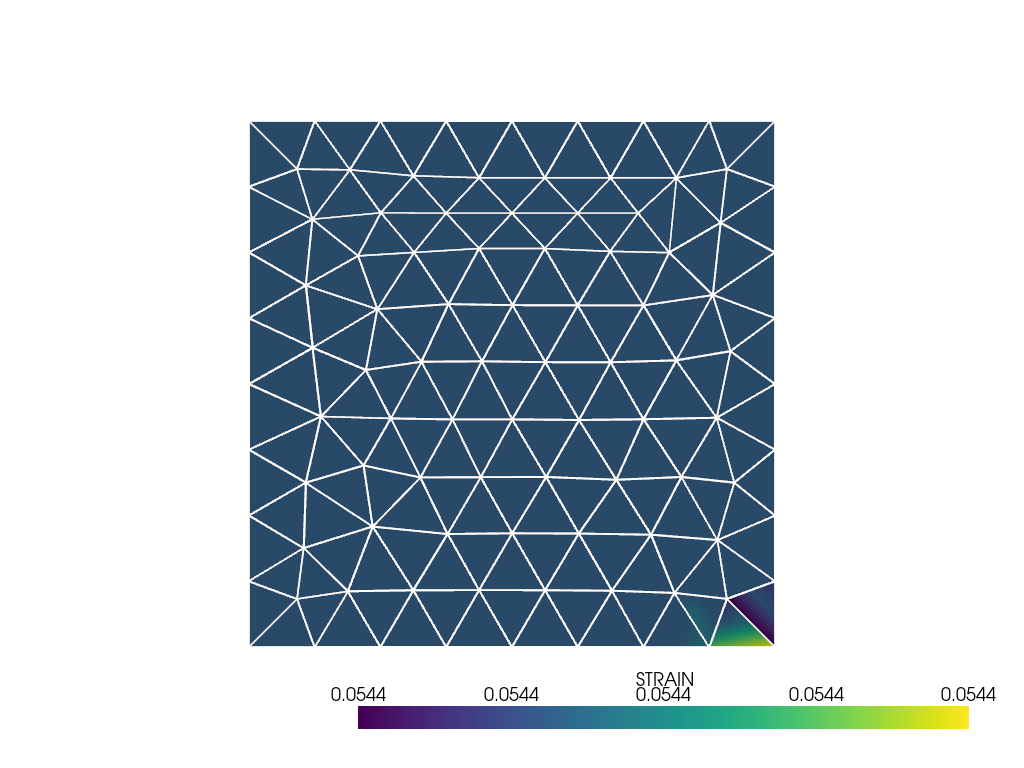

In [11]:
import pyvista as pv
pv.set_plot_theme("document")

from pyvirtualdisplay import Display
display = Display(backend="xvfb", visible=False, size=(1024, 768))
display.start()
vtk_files = subprocess.run(f"ls -c1 {params.data_dir}/*.vtk | sort -V", shell=True, text=True, capture_output=True)
if vtk_files.returncode == 0:
    files = [vtk_file for vtk_file in vtk_files.stdout.splitlines()]
    final_file = files[-1]
    print(final_file)
    mesh = pv.read(final_file)
    mesh=mesh.shrink(0.95) 
    print(mesh.array_names)
    warp_factor = 1.0
    # mesh = mesh.warp_by_vector(vectors="U", factor = warp_factor)
    # show_field = "DISPLACEMENT"
    show_field = "STRAIN" # U: displacement
    # show_field = "STRESS" # U: displacement
    
    if mesh.point_data[show_field].shape[1] > 3:
        cmap = "Spectral"
    p = pv.Plotter(notebook=True)
    p.add_mesh(mesh, scalars=show_field)
    # p.camera_position = [(-10, 0, 10), (0.0, 0.0, 0.0), (0.0, 1.0, 0.0)]
    p.camera_position = 'xy'
    p.show(jupyter_backend='ipygany')